In [41]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
from matplotlib.patches import Rectangle

#### Functions

In [42]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','init_depth']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        data_sec = datafile[var]
        dict_var[var] = data_sec[idx]
        
     
    return dict_var       

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)


def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None,NW=False):
    
    if NW == True:
        latgridf = latgridi-1 #actually lon
        fmask = mesh.fmask[0,:,:,latgridf] # Giving mask of longitudes
        tmask = mesh.tmask[0]
        
        lons = data.init_lat[(data.final_section != 0)]
        
        f_lons = mesh.gphif[0,:, latgridf]
        u_lons = mesh.gphiv[0,:, latgridf]
        w_depths = mesh.gdepw_1d
    else:
        latgridf = latgridi-1
        fmask = mesh.fmask[0, :, latgridf]
        tmask = mesh.tmask[0]
            
        lons = data.init_lon[(data.final_section != 0)]
            
        f_lons = mesh.glamf[0, latgridf]
        u_lons = mesh.glamv[0, latgridf]
        w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,2))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],2)])
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axn.add_collection(pc)
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticks([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel,NW=False):
    
    if NW == True:
        latgridf = latgridi-1 #actually lon
        fmask = mesh.fmask[0,:,:,latgridf] # Giving mask of longitudes
        tmask = mesh.tmask[0]
        
        lons = data.init_lat[(data.final_section != 0)]
        
        f_lons = mesh.gphif[0,:, latgridf]
        u_lons = mesh.gphiv[0,:, latgridf]
        w_depths = mesh.gdepw_1d
    else:
        latgridf = latgridi-1
        fmask = mesh.fmask[0, :, latgridf]
        tmask = mesh.tmask[0]
            
        lons = data.init_lon[(data.final_section != 0)]
            
        f_lons = mesh.glamf[0, latgridf]
        u_lons = mesh.glamv[0, latgridf]
        w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    try:
        im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    except:
        im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time),cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Latitude (°W)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

#### Import data

In [43]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

datafvs_haro = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forvs_haro3/01jan18_s1t50/ariane_positions_quantitative.nc')
datafpr_haro = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_haro3/01jan18_s1t50/ariane_positions_quantitative.nc')
databpr_ros = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backpr_ros3/01jan18_s1t50/ariane_positions_quantitative.nc')
databpr_haro = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backpr_haro3/01jan18_s1t50/ariane_positions_quantitative.nc')

vstopr_haro = get_secdata(datafvs_haro,6)
prtovs_haro = get_secdata(datafpr_haro,6)
haroNtopr_ros = get_secdata(databpr_ros,8)
rosNtopr_haro = get_secdata(databpr_haro,8)
gulftopr_ros = get_secdata(databpr_ros,7)

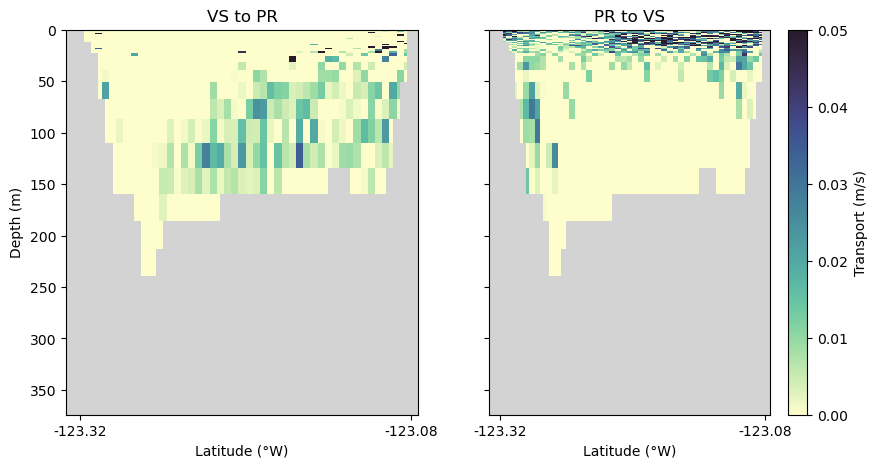

In [44]:
lonWpr = 260
lonEpr = 310
latpr = 386

fig,[ax,ax2] = plt.subplots(1,2,figsize=(10,5))

plotCS(ax,vstopr_haro['final_lon'],vstopr_haro['final_z'],vstopr_haro['final_transp'],lonWpr,lonEpr,latpr,38,0.05,23,'VS to PR',False,True)
plotCS(ax2,prtovs_haro['init_lon'],prtovs_haro['init_z'],prtovs_haro['init_transp'],lonWpr,lonEpr,latpr,38,0.05,23,'PR to VS',True,False)

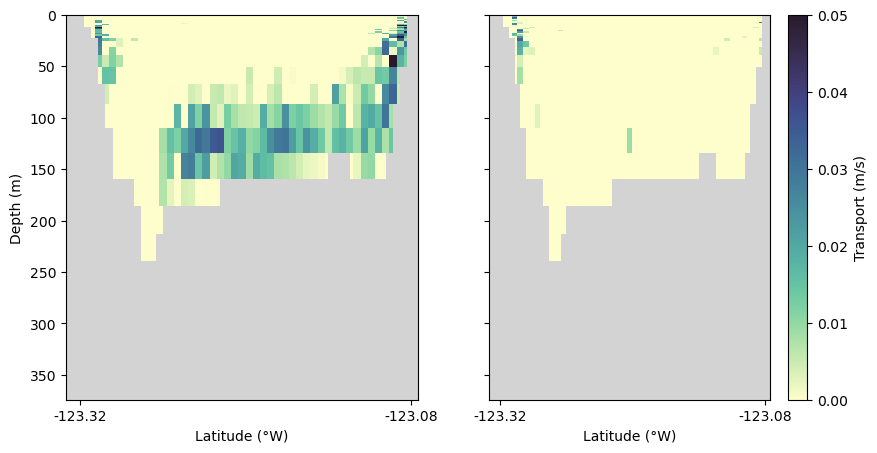

In [50]:
fig,[ax,ax2] = plt.subplots(1,2,figsize=(10,5))

plotCS(ax,haroNtopr_ros['init_lon'],haroNtopr_ros['init_z'],haroNtopr_ros['init_transp'],lonWpr,lonEpr,latpr,38,0.05,24,'',False,True)
plotCS(ax2,gulftopr_ros['init_lon'],gulftopr_ros['init_z'],gulftopr_ros['init_transp'],lonWpr,lonEpr,latpr,38,0.05,24,'',True,False)

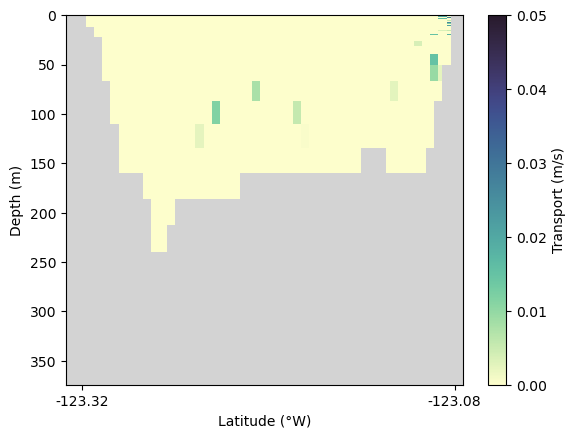

In [46]:
fig,ax = plt.subplots()

plotCS(ax,rosNtopr_haro['init_lon'],rosNtopr_haro['init_z'],rosNtopr_haro['init_transp'],lonWpr,lonEpr,latpr,38,0.05,24,'',True,True)

Figure out where that empty splot is coming from